In [1]:
from __future__ import absolute_import, division, print_function

import math
import os

import numpy as np
import prettytensor as pt
import scipy.misc
import tensorflow as tf

import scipy

from time import time

import matplotlib.pyplot as plt
%matplotlib inline

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement=True
sess = tf.Session(config=config)

In [2]:
flags = tf.flags
logging = tf.logging

flags.DEFINE_integer("batch_size", 128, "batch size")
flags.DEFINE_integer("updates_per_epoch", 1000, "number of updates per epoch")
flags.DEFINE_integer("max_epoch", 100, "max epoch")
flags.DEFINE_float("learning_rate", 1e-2, "learning rate")

flags.DEFINE_integer("dim", 1, "dimensionality of the target distribution")
flags.DEFINE_integer("gener_dim", 20, "dimensionality of the generator distribution")


FLAGS = flags.FLAGS

In [3]:
def discriminator(input_tensor):
    '''Create discriminator network.

    Args:
        input_tensor: a batch of flattened images [batch_size, 28*28]

    Returns:
        A tensor that expresses the logit of being a true sample
    '''

    return (pt.wrap(input_tensor).
            fully_connected(128).
            fully_connected(128).
            fully_connected(128).
            dropout(0.9).
            fully_connected(1, activation_fn=None)).tensor

def generator(Z=None):
    '''Create a generator network
    
    '''
    if Z==None:
        Z = tf.random_uniform([FLAGS.batch_size,FLAGS.gener_dim])
    
    return (pt.wrap(Z).
            fully_connected(128).
            fully_connected(128).
            fully_connected(128).
            fully_connected(FLAGS.dim, activation_fn=None)).tensor

def chi2_loss(Xn,Yn):
    C = tf.matmul(Xn,Yn,transpose_a=True)/FLAGS.batch_size # bias correction needed???
    chi2 = tf.reduce_sum(tf.square(C))
    return chi2

def get_gan_loss(input_tensor,generated_tensor):
    
    with tf.variable_scope("model-discriminator", reuse=True) as scope:
        D_input = discriminator(input_tensor)
    with tf.variable_scope("model-discriminator", reuse=True) as scope:
        D_generated = discriminator(generated_tensor)
        
    return tf.reduce_mean(D_input-tf.nn.softplus(D_input)-tf.nn.softplus(D_generated))

In [4]:
mtn_weights = [.3,.7]
mu = np.array([-1,1.5])
sig = np.array([.5,.5])


def mg_sampler(n,mtn_weights,mu,sig):
    mtn_samples = np.random.multinomial(1,mtn_weights,(n))
    sampl_idx = np.argmax(mtn_samples,1)
    mg_samples = np.reshape(mu[sampl_idx],[n,1])+np.reshape(sig[sampl_idx],[n,1])*np.random.randn(n,1)
    return mg_samples

In [5]:
input_tensor = tf.placeholder(tf.float32, [FLAGS.batch_size, FLAGS.dim])
learning_rate = tf.placeholder(tf.float32)

ema = tf.train.ExponentialMovingAverage(decay=0.8)

label = tf.constant(np.concatenate((np.ones([FLAGS.batch_size,1]),\
                    -np.ones([FLAGS.batch_size,1]))),dtype=tf.float32)

with tf.device('/cpu:0'):

    with pt.defaults_scope(activation_fn=tf.nn.elu,
                           batch_normalize=True,
                           learned_moments_update_rate=0.0003,
                           variance_epsilon=0.001,
                           scale_after_normalization=True):
        with pt.defaults_scope(phase=pt.Phase.train):
            with tf.variable_scope("discriminator") as scope:
                D_input = discriminator(input_tensor)
            with tf.variable_scope("generator") as scope:
                generated_tensor = generator()
            with tf.variable_scope("discriminator", reuse=True) as scope:
                D_generated = discriminator(generated_tensor)

        with pt.defaults_scope(phase=pt.Phase.test):
            with tf.variable_scope("discriminator", reuse=True) as scope:
                D_input_test = discriminator(input_tensor)
            with tf.variable_scope("generator", reuse=True) as scope:
                generated_tensor_test = generator()
            with tf.variable_scope("discriminator", reuse=True) as scope:
                D_generated_test = discriminator(generated_tensor)
                
    D = tf.sigmoid(tf.concat((D_input,D_generated),axis=0))

    D_mean,D_var = tf.nn.moments(D,axes=[0])
    maintain_averages_op = ema.apply([D_mean, D_var])

    ema_D_mean = ema.average(D_mean)
    ema_D_std = tf.sqrt(ema.average(D_var))

    Dn = (D-ema_D_mean)/ema_D_std

    data_loss = tf.reduce_mean(D_input-tf.nn.softplus(D_input))
    sampl_loss = -tf.reduce_mean(tf.nn.softplus(D_generated))
    
    discr_loss = -(data_loss+sampl_loss)
    gener_loss = chi2_loss(Dn,label)
    
    discr_vars = [v for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if v.name.startswith('discriminator')]
    gener_vars = [v for v in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES) if v.name.startswith('generator')]

    optimizer = tf.train.AdamOptimizer(learning_rate, epsilon=1.0)
    
    train_gan_discr = pt.apply_optimizer(optimizer, losses=[discr_loss], var_list=discr_vars)
    train_gan_gener = pt.apply_optimizer(optimizer, losses=[gener_loss], var_list=gener_vars)

In [15]:
# Initialization

init = tf.global_variables_initializer()
sess.run(init)

[1, 0.96895255960194115, 4.255354881286621]
[2, 0.78056235022097831, 4.176069021224976]
[3, 0.69031812775135037, 4.165186882019043]
[4, 0.66900772930681707, 4.206343173980713]
[5, 0.67335126377642152, 4.200232982635498]
[6, 0.67216155588626858, 4.183302164077759]
[7, 0.67240314877033236, 4.187428951263428]
[8, 0.67021294388175012, 4.18178391456604]
[9, 0.67004639938473698, 4.182076930999756]
[10, 0.6542552068680525, 4.189434051513672]
[11, 0.63222945697605615, 4.192257881164551]
[12, 0.59441669745743275, 4.220350980758667]
[13, 0.37847968768037388, 4.1811628341674805]
[14, 0.29552848176192492, 4.163125991821289]
[15, 0.27715672917291523, 4.186583995819092]
[16, 0.26829676187876611, 4.191543102264404]
[17, 0.28342661322001367, 4.198624849319458]
[18, 0.29587049690401179, 4.193430185317993]
[19, 0.30691336245089768, 4.191915035247803]
[20, 0.31037485868623482, 4.337645053863525]
[21, 0.30317917078733442, 4.217264890670776]
[22, 0.30381592947244646, 4.193924188613892]
[23, 0.2957883655913

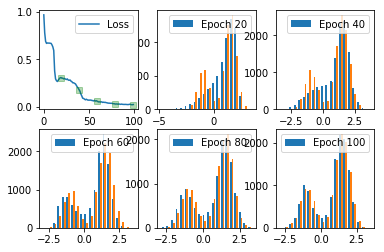

In [16]:
lr = 1e-3

MLOOP = 100

max_epoch = 100
updates_per_epoch = 1000

epoch_record = np.zeros([max_epoch,])
gener_record = list()

gener_samples = np.zeros([MLOOP*FLAGS.batch_size,])

for epoch_id in range(max_epoch):
    
    loss_record = np.zeros([updates_per_epoch,])
    
    t0 = time()
    
    for step in range(updates_per_epoch):

        x = mg_sampler(FLAGS.batch_size,mtn_weights,mu,sig)
        
        _,loss_val,_ = sess.run([train_gan_discr,discr_loss,maintain_averages_op],
                    {input_tensor: x, learning_rate: 100.*lr})
        
        _,loss_val,_ = sess.run([train_gan_gener,gener_loss,maintain_averages_op], 
                    {input_tensor: x, learning_rate: lr})
        
        loss_record[step] = loss_val
        
    if epoch_id>0 and np.mod(epoch_id+1,20)==0:
        real_samples = mg_sampler(MLOOP*FLAGS.batch_size,mtn_weights,mu,sig).reshape([-1,])
        for mloop in range(MLOOP):
            y = sess.run(generated_tensor)
            gener_samples[mloop*FLAGS.batch_size:(mloop+1)*FLAGS.batch_size] = np.reshape(y,[FLAGS.batch_size,])
        plt.subplot(2,3,np.int((epoch_id+1)/20+1))
        _,_,_ = plt.hist((gener_samples,real_samples),bins=20)
        _ = plt.legend({'Epoch %d' % (epoch_id+1)})

        gener_record.append(gener_samples)
        
        
    t1 = time()
        
    print([epoch_id+1,np.mean(loss_record),t1-t0])
    epoch_record[epoch_id] = np.mean(loss_record)

plt.subplot(2,3,1)
_ = plt.plot(epoch_record)
_ = plt.plot(range(19,max_epoch,20),epoch_record[19::20],'sg',alpha=.3)
_ = plt.legend({'Loss'})


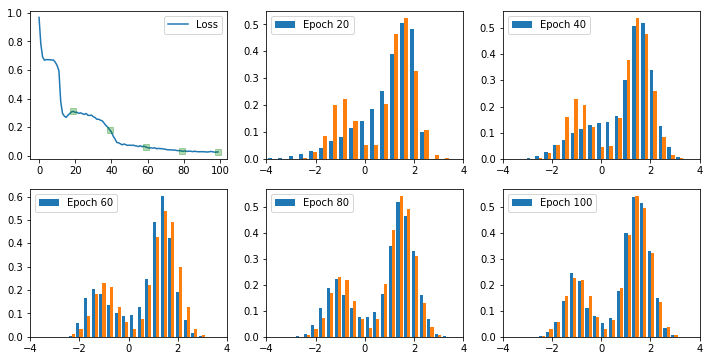

In [17]:
width = 12
height = 6
plt.figure(figsize=(width, height))

for epoch_id in range(5):
    plt.subplot(2,3,epoch_id+2)
    gener_samples = gener_record[epoch_id]
    _,_,_ = plt.hist((gener_samples,real_samples),bins=20,normed=True)
    _ = plt.legend({'Epoch %d' % ((epoch_id+1)*20)},loc='upper left')
    _ = plt.xlim([-4,4])
plt.subplot(2,3,1)
_ = plt.plot(epoch_record)
_ = plt.plot(range(19,max_epoch,20),epoch_record[19::20],'sg',alpha=.3)
_ = plt.legend(['Loss'])